<a href="https://colab.research.google.com/github/dimoynwa/Computer-vision-tasks/blob/main/RT_DETR_Face_parts_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train and test RT-DETR on Face parts (nose, mouth, eyes) dataset

Steps in the tutorial:

- Environment setup
- Install libraries
- Download dataset from `roboflow`
- Train RT-DETR on that dataset
- Deploy model to `roboflow`

## Environment

Check `python` and `pip` versions.

Make sure GPU is available using `nvidia-smi` command. It should return anything, this indicates that `cuda` is available

In [ ]:
!python --version
!pip --version
!nvidia-smi

import locale
locale.getpreferredencoding = lambda: "UTF-8"

Python 3.10.12
pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Sat Nov 16 07:32:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |   

Configure **HOME** directory.



In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


Import `pytorch` and check `pytorch` and `cuda` versions.

In [ ]:
import torch

!nvcc --version
TORCH_VERSION = torch.__version__
CUDA_VERSION = torch.__version__.split('+')[-1]

print(f'Torch version: {TORCH_VERSION}')
print(f'CUDA version: {CUDA_VERSION}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Torch version: 2.5.1+cu121
CUDA version: cu121


## Install transformers

`RT-DETR` is in main version version of `transformers` package, which requires installation from source. If you'd like regular pip install, checkout the latest stable version (v4.42.0).

In [ ]:
!pip install -q transformers
!pip install -q supervision
!pip install -q accelerate roboflow torchmetrics
!pip install -q "albumentations>=1.4.5"

from IPython.display import clear_output
clear_output()

from transformers import __version__ as transformers_version
print(f'transformers version: {transformers_version}')

import supervision as sv
print(f'supervision version: {sv.__version__}')

import roboflow
print(f'roboflow version: {roboflow.__version__}')

import torchmetrics
print(f'torchmetrics version: {torchmetrics.__version__}')

import albumentations
print(f'albumentations version: {albumentations.__version__}')


transformers version: 4.46.2
supervision version: 0.25.0
roboflow version: 1.1.49
torchmetrics version: 1.6.0
albumentations version: 1.4.20


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


## Load pre-trained RT-DETR model

We choose the checkpoint we want to use and then initialize the model and processor. In the transformers library, the model encapsulates the architecture and learned parameters. We train the model for mobile, thats why we choose `PekingU/rtdetr_r18vd`, which uses the smallest ResNet model and is super lightweight.

In [ ]:
import torch
from transformers import AutoModelForObjectDetection, AutoImageProcessor

CHECKPOINT = 'PekingU/rtdetr_r50vd_coco_o365'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

Device: cuda


config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor

CHECKPOINT = 'PekingU/rtdetr_r50vd_coco_o365'

processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

## Inference before train



Let's run simple inference on test images from Google drive. Then we will use `supervision` to display predicted boxes.

In [ ]:
from google.colab import drive
drive.mount(f'{HOME}/drive')

Mounted at /content/drive


In [ ]:
import os

GOOGLE_DRIVE_DATA_PATH = f'{HOME}/drive/MyDrive/Data'
ZIDANE_IMG = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'zidane.jpg')
FIRMINO_IMG = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'firmino.jpg')

assert os.path.exists(ZIDANE_IMG)
assert os.path.exists(FIRMINO_IMG)

In [ ]:
from PIL import Image

image = Image.open(ZIDANE_IMG)
inputs = processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

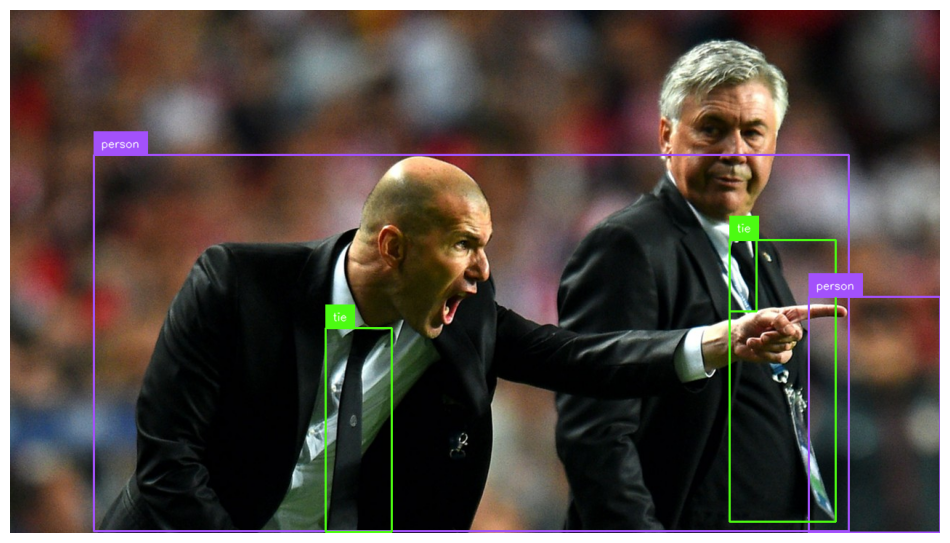

In [ ]:
detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(
    annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(
    annotated_image, detections, labels=labels)

sv.plot_image(annotated_image)

## Prepare Dataset for Training RT-DETR

For training we will use

In [ ]:
from google.colab import userdata
roboflow_api_key = userdata.get('roboflow_api_key')
print(f'Roboflow API key: {roboflow_api_key[:2]}**{roboflow_api_key[-2:]}')

%cd {HOME}

from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace("test-70hyp").project("face-parts-kd1oo")
version = project.version(1)
dataset = version.download("coco")

Roboflow API key: yh**ot
[Errno 2] No such file or directory: '{HOME}'
/content
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face-parts-1 in coco:: 100%|██████████| 12855/12855 [00:02<00:00, 5631.53it/s]


## Load Dataset

`supervision` provides easy to use interface for creating DetectionDataset. It also easily integrates with `PyTorch Dataset`. PyTorch Dataset is an abstract class that provides a convenient way to access and process data samples in a standardized format.

In [ ]:
import os
import supervision as sv

print(f'Dataset location: {dataset.location}')
assert os.path.exists(dataset.location)
assert os.path.exists(f'{dataset.location}/train')
assert os.path.exists(f'{dataset.location}/valid')
assert os.path.exists(f'{dataset.location}/test')

ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

Dataset location: /content/Face-parts-1


In [ ]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}

print(f'id2label: {id2label}')
print(f'label2id: {label2id}')

id2label: {0: 'face-nose-eye-mounth', 1: '0', 2: '1', 3: '2'}
label2id: {'face-nose-eye-mounth': 0, '0': 1, '1': 2, '2': 3}


### Visualize random samples

Dataset len: 1054


images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


Choosen: ['/content/Face-parts-1/valid/16257_jpg.rf.aebe55d0d446b67fc78261fd3c8b4d9a.jpg', '/content/Face-parts-1/valid/5054_jpg.rf.a0fcd139ac533a87ae90f515200d1a35.jpg', '/content/Face-parts-1/valid/3071_jpg.rf.edd0afbce55b04ccfcfe6b0d34486be6.jpg']
CLASS_NAME_DICT: {0: 'face-nose-eye-mounth', 1: '0', 2: '1', 3: '2'}
Image shape: (640, 640, 3)
Detections: Detections(xyxy=array([[310, 228, 410, 348],
       [254, 206, 346, 266],
       [362, 220, 446, 276],
       [266, 322, 406, 406]]), mask=None, confidence=None, class_id=array([1, 2, 2, 3]), tracker_id=None, data={}, metadata={})
Image shape: (640, 640, 3)
Detections: Detections(xyxy=array([[249. , 168. , 321. , 306. ],
       [217. , 156. , 281.5, 199. ],
       [324. , 166. , 405.5, 213.5],
       [238. , 306. , 352. , 370. ]]), mask=None, confidence=None, class_id=array([1, 2, 2, 3]), tracker_id=None, data={}, metadata={})
Image shape: (640, 640, 3)
Detections: Detections(xyxy=array([[310. , 230. , 405.5, 362.5],
       [252. , 2

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


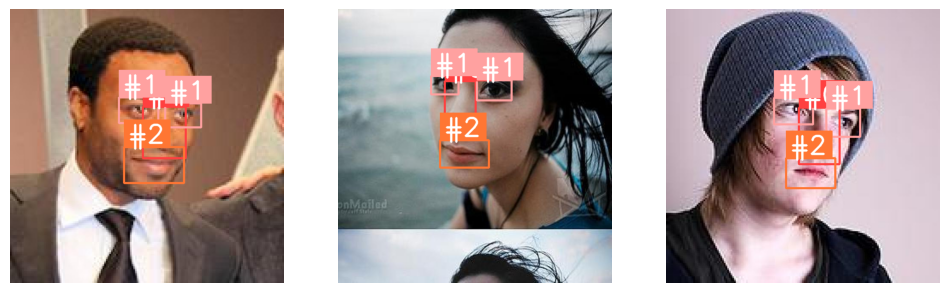

In [ ]:
import random
import cv2

len_ds = len(ds_valid)
print(f'Dataset len: {len_ds}')

choosen = random.choices(list(ds_valid.images.keys()), k=3)
print(f'Choosen: {choosen}')

box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

CLASS_NAME_DICT = { idx: label for idx, label in enumerate(ds_valid.classes) }
print(f'CLASS_NAME_DICT: {CLASS_NAME_DICT}')

frames = []

for img_src in choosen:
  image = cv2.imread(img_src)
  detections = ds_valid.annotations[img_src]

  labels = [
    f'#{CLASS_NAME_DICT[class_id]}'
    for class_id in detections.class_id
  ]

  print(f'Image shape: {image.shape}')
  print(f'Detections: {detections}')

  frame = box_annotator.annotate(image, detections)
  frame = label_annotator.annotate(frame, detections, labels=labels)

  frames.append(frame)

sv.plot_images_grid(frames, (1, len(frames)))

## Data Augmentations for Training RT-DETR

This technique artificially increases the size and diversity of the training dataset, helping the model generalize better and become more robust to variations in real-world data.

In [ ]:
import albumentations as A

augmentation_train = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

augmentation_valid = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

## Define PyTorch Dataset

 Let's define a PyTorch Dataset that will load annotations from disk, augment them, and return them in the format expected by the RT-DETR processor.

In [ ]:
from torch.utils.data import Dataset

class AugmentedDetectionDataset(Dataset):
    def __init__(self, dataset, processor, transform):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        image = image[:, :, ::-1]
        transformed = self.transform(
            image=image,
            bboxes=annotations.xyxy,
            category=annotations.class_id
        )
        image = transformed["image"]
        boxes = transformed["bboxes"]
        categories = transformed["category"]

        formatted_annotations = self.annotations_as_coco(
            image_id=idx,
            categories=categories,
            boxes=boxes
        )
        result = self.processor(
            images=image,
            annotations=formatted_annotations,
            return_tensors="pt"
        )

        return {k: v[0] for k, v in result.items()}

In [ ]:
dataset_train = AugmentedDetectionDataset(
    ds_train, processor, transform=augmentation_train)
dataset_valid = AugmentedDetectionDataset(
    ds_valid, processor, transform=augmentation_valid)
dataset_test = AugmentedDetectionDataset(
    ds_test, processor, transform=augmentation_valid)

print(f'Dataset train len: {len(dataset_train)}')
print(f'Dataset valid len: {len(dataset_valid)}')
print(f'Dataset test len: {len(dataset_test)}')

dataset_train[1]

Dataset train len: 11373
Dataset valid len: 1054
Dataset test len: 420


{'pixel_values': tensor([[[0.1647, 0.1647, 0.1647,  ..., 0.1686, 0.1686, 0.1686],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1608, 0.1608, 0.1608],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.1961, 0.1843, 0.1765],
          [1.0000, 1.0000, 1.0000,  ..., 0.2118, 0.2039, 0.2039],
          [1.0000, 1.0000, 1.0000,  ..., 0.2235, 0.2353, 0.2510]],
 
         [[0.1647, 0.1647, 0.1647,  ..., 0.1686, 0.1686, 0.1686],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1608, 0.1608, 0.1608],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.1961, 0.1843, 0.1765],
          [1.0000, 1.0000, 1.0000,  ..., 0.2118, 0.2039, 0.2039],
          [1.0000, 1.0000, 1.0000,  ..., 0.2235, 0.2353, 0.2510]],
 
         [[0.1647, 0.1647, 0.1647,  ..., 0.1686, 0.1686, 0.1686],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.164

We have successfully augmented the images and prepared their annotations. In the final step, create a custom collate_fn to batch images together.

In [ ]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

## Prepare the model

Training involves the following steps:

- Load the model with [`AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
- Define your training hyperparameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
- Pass the training arguments to [`Trainer`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
- Call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id` and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [ ]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}

CHECKPOINT = 'PekingU/rtdetr_r50vd_coco_o365'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

Device: cuda


Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([4]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([4]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([4]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- model.

## Before start the training

Let's log into `ClearML`

Also we need to set A TrainerCallback that sends the logs to ClearML.
For that purpose we need to provide the following environment variables.

Environment:

- `CLEARML_PROJECT` (str, optional, defaults to HuggingFace Transformers): ClearML project name.
- `CLEARML_TASK` (str, optional, defaults to Trainer): ClearML task name.
- `CLEARML_LOG_MODEL` (bool, optional, defaults to False): Whether to log models as artifacts during training.

In [ ]:
!pip install clearml

from IPython.display import clear_output
clear_output()

import clearml
print(f'ClearML version: {clearml.__version__}')

ClearML version: 1.16.5


Set environment variables

In [ ]:
import os

os.environ['CLEARML_PROJECT'] = 'Face parts detection'
os.environ['CLEARML_TASK'] = 'RTDETR PekingU/rtdetr_r50vd_coco_o365'
os.environ['CLEARML_LOG_MODEL'] = 'True'

!export | grep CLEARML

declare -x CLEARML_LOG_MODEL="True"
declare -x CLEARML_PROJECT="Face parts detection"
declare -x CLEARML_TASK="RTDETR PekingU/rtdetr_r50vd_coco_o365"


Log into `ClearML`

In [ ]:
import clearml

clearml.browser_login()

# Clear log because Access and Secret keys are there
from IPython import display
display.clear_output()

## Evaluation mAP (Mean average precision)

Mean Average Precision is a metric used to measure the performance of a model for tasks such as object detection tasks and information retrieval. mAP leverages these sub-metrics: Confused Matrix, Intersection over Union(IoU), Recall, and Precision.

In [ ]:
from dataclasses import dataclass, replace
from transformers import TrainingArguments, Trainer
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import numpy as np
import torch

id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}

print(f'id2label: {id2label}')
print(f'label2id: {label2id}')

@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

id2label: {0: 'face-nose-eye-mounth', 1: '0', 2: '1', 3: '2'}
label2id: {'face-nose-eye-mounth': 0, '0': 1, '1': 2, '2': 3}


In the [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit.

Important notes:

- Set `eval_do_concat_batches=False` to get proper evaluation results. Images have different number of target boxes, if batches are concatenated we will not be able to determine which boxes belongs to particular image.

In [ ]:
train_batch_size = 32
eval_batch_size = 16
warmup_steps = len(dataset_train) // train_batch_size

training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=200,
    max_grad_norm=0.1,
    learning_rate=1e-5,
    warmup_steps=warmup_steps,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


ClearML Task: created new task id=bc880ae9696640d08f650d7bf5cacccf
ClearML results page: https://app.clear.ml/projects/3d72a693d1504c10a24dda3d8358cf80/experiments/bc880ae9696640d08f650d7bf5cacccf/output/log
2024-11-15 15:05:53,482 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])
2024-11-15 15:05:54,820 - clearml.Task - INFO - Storing jupyter notebook directly as code


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Face-nose-eye-mounth,Mar 100 Face-nose-eye-mounth,Map 0,Mar 100 0,Map 1,Mar 100 1,Map 2,Mar 100 2
1,No log,24.768606,0.037600,0.087600,0.028300,0.007600,0.053500,0.027100,0.082800,0.182800,0.238600,0.073300,0.233000,0.284300,-1.000000,-1.000000,0.000200,0.098000,0.045800,0.373300,0.066900,0.244300
2,39.776400,17.877542,0.152500,0.281000,0.156600,0.073300,0.181800,0.069900,0.180900,0.290300,0.331100,0.216000,0.345300,0.315800,-1.000000,-1.000000,0.000100,0.089700,0.220000,0.510400,0.237500,0.393100
3,12.966900,15.489786,0.205000,0.364300,0.213500,0.111800,0.234900,0.117100,0.227000,0.340300,0.424000,0.232100,0.428700,0.443900,-1.000000,-1.000000,0.000600,0.179200,0.233200,0.560200,0.381200,0.532800
4,12.966900,14.593679,0.282900,0.477700,0.314900,0.152100,0.293500,0.206700,0.285300,0.387800,0.458500,0.265600,0.450200,0.507900,-1.000000,-1.000000,0.000500,0.154500,0.335800,0.617400,0.512500,0.603500
5,10.400700,13.191923,0.292400,0.477500,0.336800,0.220100,0.322700,0.153800,0.276600,0.385000,0.440500,0.362600,0.459500,0.421900,-1.000000,-1.000000,0.000300,0.123100,0.416800,0.653900,0.460000,0.544600
6,9.023600,13.033326,0.300400,0.493400,0.336800,0.223200,0.327100,0.158700,0.284000,0.385500,0.422800,0.347300,0.437300,0.424700,-1.000000,-1.000000,0.000100,0.070300,0.438700,0.648100,0.462300,0.550100
7,9.023600,11.907539,0.302500,0.498500,0.341200,0.225200,0.331100,0.170700,0.300200,0.406300,0.448400,0.375600,0.469300,0.431600,-1.000000,-1.000000,0.000200,0.089000,0.404000,0.656500,0.503400,0.599800
8,8.395600,11.254964,0.324300,0.534800,0.355600,0.215900,0.340800,0.245100,0.313500,0.417900,0.469500,0.355000,0.476200,0.481400,-1.000000,-1.000000,0.000200,0.115600,0.433400,0.658000,0.539300,0.634900
9,7.857000,10.840203,0.312700,0.534100,0.340700,0.267000,0.324700,0.226000,0.312100,0.422300,0.483900,0.421400,0.490800,0.479300,-1.000000,-1.000000,0.000500,0.159400,0.418700,0.654500,0.518900,0.637800
10,7.620100,10.648928,0.341300,0.571300,0.381100,0.259100,0.355700,0.277900,0.327200,0.428000,0.467800,0.388500,0.487000,0.439300,-1.000000,-1.000000,0.000200,0.091600,0.461900,0.649700,0.561700,0.662100


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2024-11-15 15:12:01,810 - clearml.storage - INFO - Uploading: 488.47MB to /tmp/model_package.8bym4zqn.zip


████████████████████████████▉ 100% | 488.47/488.47 MB [00:47<00:00, 10.32MB/s]: 

2024-11-15 15:12:49,171 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-356.zip


2024-11-15 15:17:52,692 - clearml.storage - INFO - Uploading: 488.47MB to /tmp/model_package.2_v5jhqa.zip


████████████████████████████▉ 100% | 488.47/488.47 MB [00:47<00:00, 10.21MB/s]: 

2024-11-15 15:18:40,555 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-712.zip


2024-11-15 15:23:43,914 - clearml.storage - INFO - Uploading: 488.47MB to /tmp/model_package.g8jwc_s9.zip


████████████████████████████▉ 100% | 488.47/488.47 MB [00:47<00:00, 10.24MB/s]: 

2024-11-15 15:24:31,643 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-1068.zip


2024-11-15 15:29:38,461 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.kb58a6_a.zip


████████████████████████████▉ 100% | 488.47/488.48 MB [00:44<00:00, 10.64MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.48/488.48 MB [00:49<00:00,  9.96MB/s]: 

2024-11-15 15:30:27,506 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-1424.zip


2024-11-15 15:35:38,195 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.hk_vyxtk.zip


████████████████████████████▉ 100% | 488.47/488.48 MB [00:46<00:00, 10.40MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.48/488.48 MB [00:50<00:00,  9.63MB/s]: 

2024-11-15 15:36:28,906 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-1780.zip


2024-11-15 15:41:31,090 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.w4tjt1bs.zip


████████████████████████████▉ 100% | 488.47/488.48 MB [00:43<00:00, 10.88MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.48/488.48 MB [00:47<00:00, 10.21MB/s]: 

2024-11-15 15:42:18,950 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-2136.zip


2024-11-15 15:47:22,682 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.1sxkpoat.zip


████████████████████████████▉ 100% | 488.47/488.48 MB [00:43<00:00, 11.19MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.48/488.48 MB [00:47<00:00, 10.21MB/s]: 

2024-11-15 15:48:10,560 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-2492.zip


2024-11-15 15:53:17,632 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.jgnofkbp.zip


█████████████████████████████ 100% | 488.48/488.48 MB [00:43<00:00, 12.11MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.48/488.48 MB [00:48<00:00, 10.12MB/s]: 

2024-11-15 15:54:05,937 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-2848.zip


2024-11-15 15:59:15,792 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.c40_gi_o.zip


████████████████████████████▉ 100% | 488.48/488.48 MB [00:49<00:00,  9.88MB/s]: 

2024-11-15 16:00:05,265 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-3204.zip


2024-11-15 16:05:07,340 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.mgc2o3za.zip


█████████████████████████████ 100% | 488.48/488.48 MB [00:46<00:00, 12.14MB/s]: 

2024-11-15 16:05:55,860 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.mgc2o3za.zip



                                          0% | 0.00/488.48 MB [00:00<?, ?MB/s]: 
▌                                2% | 10.00/488.48 MB [00:00<00:20, 22.97MB/s]: 
▉                                3% | 15.00/488.48 MB [00:00<00:29, 16.09MB/s]: 
█▏                               4% | 20.00/488.48 MB [00:01<00:33, 13.87MB/s]: 
█▌                               5% | 25.00/488.48 MB [00:01<00:35, 12.88MB/s]: 
█▊                               6% | 30.00/488.48 MB [00:02<00:37, 12.32MB/s]: 
██▏                              7% | 35.00/488.48 MB [00:02<00:37, 11.99MB/s]: 
██▍                              8% | 40.00/488.48 MB [00:03<00:38, 11.72MB/s]: 
██▊                              9% | 45.00/488.48 MB [00:03<00:38, 11.60MB/s]: 
███                             10% | 50.00/488.48 MB [00:03<00:38, 11.51MB/s]: 
███▍                            11% | 55.00/488.48 MB [00:04<00:37, 11.45MB/s]: 
███▋                            12% | 60.00/488.48 MB [00:04<00:37, 11.43MB/s]: 
███▉                       

2024-11-15 16:06:43,941 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-3560.zip



████████████████████████████▉ 100% | 488.48/488.48 MB [02:02<00:00,  3.99MB/s]: 


2024-11-15 16:11:02,020 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.9glwphbg.zip


████████████████████████████▉ 100% | 488.48/488.48 MB [00:48<00:00, 10.14MB/s]: 

2024-11-15 16:11:50,213 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-3916.zip


2024-11-15 16:16:58,631 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.x9xj0_eb.zip


████████████████████████████▉ 100% | 488.48/488.48 MB [00:47<00:00, 10.22MB/s]: 

2024-11-15 16:17:46,459 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-4272.zip


2024-11-15 16:22:51,920 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.t1bw7dc8.zip


████████████████████████████▉ 100% | 488.48/488.48 MB [00:47<00:00, 10.21MB/s]: 

2024-11-15 16:23:39,774 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-4628.zip


2024-11-15 16:28:45,918 - clearml.storage - INFO - Uploading: 488.48MB to /tmp/model_package.dclj7kq_.zip


████████████████████████████▉ 100% | 488.47/488.48 MB [00:48<00:00, 10.17MB/s]: 

2024-11-15 16:29:33,957 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-4984.zip


2024-11-15 16:34:39,795 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.cb3rn1_9.zip


████████████████████████████▉ 100% | 488.48/488.49 MB [00:43<00:00, 11.68MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.49/488.49 MB [00:47<00:00, 10.23MB/s]: 

2024-11-15 16:35:27,544 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-5340.zip


2024-11-15 16:40:41,166 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.mgpc9js6.zip


████████████████████████████▉ 100% | 488.48/488.49 MB [00:43<00:00, 12.13MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.49/488.49 MB [00:48<00:00, 10.18MB/s]: 

2024-11-15 16:41:29,179 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-5696.zip


2024-11-15 16:46:36,511 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.2q7_ivx0.zip


████████████████████████████▉ 100% | 488.48/488.49 MB [00:43<00:00, 12.11MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.49/488.49 MB [00:48<00:00, 10.18MB/s]: 

2024-11-15 16:47:24,528 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-6052.zip


2024-11-15 16:52:32,400 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.zo_j70cb.zip


████████████████████████████▉ 100% | 488.48/488.49 MB [00:43<00:00, 12.01MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.49/488.49 MB [00:47<00:00, 10.19MB/s]: 

2024-11-15 16:53:20,372 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-6408.zip


2024-11-15 16:58:29,656 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.6r92u4_9.zip


████████████████████████████▉ 100% | 488.48/488.49 MB [00:43<00:00, 12.08MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.49/488.49 MB [00:48<00:00, 10.16MB/s]: 

2024-11-15 16:59:17,770 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-6764.zip


2024-11-15 17:04:30,185 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.d3dqgp8k.zip


████████████████████████████▉ 100% | 488.49/488.49 MB [00:48<00:00, 10.06MB/s]: 

2024-11-15 17:05:18,767 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-7120.zip


2024-11-15 17:10:25,209 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.vyfi024l.zip


████████████████████████████▉ 100% | 488.49/488.49 MB [00:47<00:00, 10.18MB/s]: 

2024-11-15 17:11:13,185 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-7476.zip


2024-11-15 17:16:21,749 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.lvtcwcv9.zip


████████████████████████████▉ 100% | 488.49/488.49 MB [00:47<00:00, 10.20MB/s]: 

2024-11-15 17:17:09,650 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-7832.zip


2024-11-15 17:22:16,766 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.tj898tnq.zip


████████████████████████████▉ 100% | 488.49/488.49 MB [00:48<00:00, 10.03MB/s]: 

2024-11-15 17:23:05,463 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-8188.zip


2024-11-15 17:28:15,585 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.7kn44czi.zip


████████████████████████████▉ 100% | 488.49/488.49 MB [00:49<00:00,  9.95MB/s]: 

2024-11-15 17:29:04,685 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-8544.zip


2024-11-15 17:34:11,665 - clearml.storage - INFO - Uploading: 488.49MB to /tmp/model_package.w99qvsug.zip


████████████████████████████▉ 100% | 488.49/488.49 MB [00:48<00:00, 10.08MB/s]: 

2024-11-15 17:35:00,130 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-8900.zip


2024-11-15 17:40:08,676 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.ib6_aqxx.zip


██████████████████████████████ 100% | 488.50/488.5 MB [00:43<00:00, 12.12MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

██████████████████████████████ 100% | 488.50/488.5 MB [00:47<00:00, 10.21MB/s]: 

2024-11-15 17:40:56,536 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-9256.zip


2024-11-15 17:46:02,696 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.9tw6jni5.zip


██████████████████████████████ 100% | 488.50/488.5 MB [00:44<00:00, 11.27MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

██████████████████████████████ 100% | 488.50/488.5 MB [00:48<00:00,  9.99MB/s]: 

2024-11-15 17:46:51,584 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-9612.zip


2024-11-15 17:52:01,388 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.niijgiyw.zip


██████████████████████████████ 100% | 488.50/488.5 MB [00:43<00:00, 11.93MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

██████████████████████████████ 100% | 488.50/488.5 MB [00:47<00:00, 10.18MB/s]: 

2024-11-15 17:52:49,389 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-9968.zip


2024-11-15 17:57:56,453 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.1st7g_p1.zip


██████████████████████████████ 100% | 488.50/488.5 MB [00:43<00:00, 12.17MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

██████████████████████████████ 100% | 488.50/488.5 MB [00:48<00:00, 10.13MB/s]: 

2024-11-15 17:58:44,673 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-10324.zip


2024-11-15 18:03:52,508 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.jyt081px.zip


██████████████████████████████ 100% | 488.50/488.5 MB [00:43<00:00, 11.39MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

██████████████████████████████ 100% | 488.50/488.5 MB [00:48<00:00, 10.07MB/s]: 

2024-11-15 18:04:41,035 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-10680.zip


2024-11-15 18:09:49,304 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.at42s_f2.zip


█████████████████████████████▉ 100% | 488.50/488.5 MB [00:48<00:00, 10.04MB/s]: 

2024-11-15 18:10:37,947 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-11036.zip


2024-11-15 18:15:54,806 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.eanud5hi.zip


█████████████████████████████▉ 100% | 488.50/488.5 MB [01:12<00:00,  6.73MB/s]: 

2024-11-15 18:17:07,408 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-11392.zip


2024-11-15 18:21:50,092 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.q7hwo4yn.zip


█████████████████████████████▉ 100% | 488.50/488.5 MB [00:58<00:00,  8.35MB/s]: 

2024-11-15 18:22:48,585 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-11748.zip


2024-11-15 18:27:47,334 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.hakodt2k.zip


█████████████████████████████▉ 100% | 488.50/488.5 MB [01:46<00:00,  4.59MB/s]: 

2024-11-15 18:29:33,735 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-12104.zip


2024-11-15 18:33:43,676 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.ofwxrx3b.zip


█████████████████████████████▉ 100% | 488.50/488.5 MB [00:56<00:00,  8.69MB/s]: 

2024-11-15 18:34:39,901 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-12460.zip


2024-11-15 18:39:44,673 - clearml.storage - INFO - Uploading: 488.50MB to /tmp/model_package.3lb4aa37.zip


█████████████████████████████▉ 100% | 488.49/488.5 MB [00:48<00:00, 10.04MB/s]: 

2024-11-15 18:40:33,342 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-12816.zip


2024-11-15 18:45:40,475 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.oq0x82mv.zip


████████████████████████████▉ 100% | 488.50/488.51 MB [00:44<00:00, 10.07MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.51/488.51 MB [00:48<00:00,  9.99MB/s]: 

2024-11-15 18:46:29,409 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-13172.zip


2024-11-15 18:51:36,867 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.etdw1k57.zip


████████████████████████████▉ 100% | 488.50/488.51 MB [00:43<00:00, 12.12MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.51/488.51 MB [00:48<00:00, 10.15MB/s]: 

2024-11-15 18:52:25,008 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-13528.zip


2024-11-15 18:57:33,840 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.93pyfs9w.zip


████████████████████████████▉ 100% | 488.50/488.51 MB [00:43<00:00, 11.68MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.51/488.51 MB [00:48<00:00, 10.14MB/s]: 

2024-11-15 18:58:22,020 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-13884.zip


2024-11-15 19:03:32,138 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.z37y2uh4.zip


████████████████████████████▉ 100% | 488.50/488.51 MB [00:42<00:00, 11.43MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.51/488.51 MB [00:47<00:00, 10.39MB/s]: 

2024-11-15 19:04:19,181 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-14240.zip


2024-11-15 19:09:22,891 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.l6vv0vaa.zip


████████████████████████████▉ 100% | 488.50/488.51 MB [00:42<00:00, 11.54MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.51/488.51 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 19:10:10,274 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-14596.zip


2024-11-15 19:15:14,320 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.7ejpxrn6.zip


████████████████████████████▉ 100% | 488.51/488.51 MB [00:47<00:00, 10.32MB/s]: 

2024-11-15 19:16:01,665 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-14952.zip


2024-11-15 19:21:05,263 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.bam71405.zip


████████████████████████████▉ 100% | 488.51/488.51 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 19:21:52,650 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-15308.zip


2024-11-15 19:26:59,391 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.5x0thlog.zip


████████████████████████████▉ 100% | 488.51/488.51 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 19:27:46,799 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-15664.zip


2024-11-15 19:32:50,499 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.crz1rclx.zip


████████████████████████████▉ 100% | 488.51/488.51 MB [00:47<00:00, 10.36MB/s]: 

2024-11-15 19:33:37,682 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-16020.zip


2024-11-15 19:38:41,859 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.4prwlard.zip


████████████████████████████▉ 100% | 488.51/488.51 MB [00:47<00:00, 10.26MB/s]: 

2024-11-15 19:39:29,466 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-16376.zip


2024-11-15 19:44:33,455 - clearml.storage - INFO - Uploading: 488.51MB to /tmp/model_package.2dll3lh3.zip


████████████████████████████▉ 100% | 488.50/488.51 MB [00:47<00:00, 10.28MB/s]: 

2024-11-15 19:45:20,983 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-16732.zip


2024-11-15 19:50:28,482 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.tg8b4ulw.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:42<00:00, 11.57MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.52 MB [00:47<00:00, 10.32MB/s]: 

2024-11-15 19:51:15,821 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-17088.zip


2024-11-15 19:56:19,158 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package._bhjvlo3.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:42<00:00, 11.49MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.52 MB [00:47<00:00, 10.29MB/s]: 

2024-11-15 19:57:06,625 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-17444.zip


2024-11-15 20:02:18,090 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.e2w8tgva.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:43<00:00, 11.32MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.52 MB [00:47<00:00, 10.26MB/s]: 

2024-11-15 20:03:05,736 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-17800.zip


2024-11-15 20:08:16,205 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.1tqqxeq1.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:42<00:00, 11.40MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.52 MB [00:47<00:00, 10.33MB/s]: 

2024-11-15 20:09:03,492 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-18156.zip


2024-11-15 20:14:12,686 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.gap6tqpd.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:42<00:00, 11.45MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.52/488.52 MB [00:47<00:00, 10.35MB/s]: 

2024-11-15 20:14:59,902 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-18512.zip


2024-11-15 20:20:09,544 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.xo9n12y_.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:43<00:00, 11.74MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.52/488.52 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 20:20:56,958 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-18868.zip


2024-11-15 20:26:02,310 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.8fs64gst.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:42<00:00, 12.06MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.52/488.52 MB [00:47<00:00, 10.28MB/s]: 

2024-11-15 20:26:49,849 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-19224.zip


2024-11-15 20:31:58,745 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.3y0phgmn.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:42<00:00, 11.41MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.52/488.52 MB [00:47<00:00, 10.33MB/s]: 

2024-11-15 20:32:46,032 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-19580.zip


2024-11-15 20:37:51,888 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.bkwtlbir.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:42<00:00, 11.43MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.52/488.52 MB [00:47<00:00, 10.29MB/s]: 

2024-11-15 20:38:39,400 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-19936.zip


2024-11-15 20:43:45,910 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.2np_wl8m.zip


█████████████████████████████ 100% | 488.52/488.52 MB [00:42<00:00, 11.48MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.52/488.52 MB [00:47<00:00, 10.26MB/s]: 

2024-11-15 20:44:33,556 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-20292.zip


2024-11-15 20:49:39,784 - clearml.storage - INFO - Uploading: 488.52MB to /tmp/model_package.jmvk2kkl.zip


████████████████████████████▉ 100% | 488.52/488.52 MB [00:47<00:00, 10.32MB/s]: 

2024-11-15 20:50:27,143 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-20648.zip


2024-11-15 20:55:36,949 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.l3rbud73.zip


█████████████████████████████ 100% | 488.53/488.53 MB [00:42<00:00, 12.12MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.53 MB [00:47<00:00, 10.33MB/s]: 

2024-11-15 20:56:24,248 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-21004.zip


2024-11-15 21:01:30,366 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.2zmfmwgk.zip


█████████████████████████████ 100% | 488.53/488.53 MB [00:42<00:00, 11.49MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.53 MB [00:46<00:00, 10.42MB/s]: 

2024-11-15 21:02:17,267 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-21360.zip


2024-11-15 21:07:23,174 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.q69h0gc0.zip


█████████████████████████████ 100% | 488.53/488.53 MB [00:42<00:00, 11.28MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.53 MB [00:47<00:00, 10.29MB/s]: 

2024-11-15 21:08:10,644 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-21716.zip


2024-11-15 21:13:22,267 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.5rvlqiw0.zip


█████████████████████████████ 100% | 488.53/488.53 MB [00:42<00:00, 11.52MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.53 MB [00:47<00:00, 10.35MB/s]: 

2024-11-15 21:14:09,474 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-22072.zip


2024-11-15 21:19:19,154 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.97pnluku.zip


█████████████████████████████ 100% | 488.53/488.53 MB [00:42<00:00,  9.84MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.53/488.53 MB [00:47<00:00, 10.34MB/s]: 

2024-11-15 21:20:06,432 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-22428.zip


2024-11-15 21:25:12,891 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.gst94tjs.zip


████████████████████████████▉ 100% | 488.53/488.53 MB [00:47<00:00, 10.18MB/s]: 

2024-11-15 21:26:00,873 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-22784.zip


2024-11-15 21:31:05,719 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.gziizxk2.zip


████████████████████████████▉ 100% | 488.53/488.53 MB [00:47<00:00, 10.35MB/s]: 

2024-11-15 21:31:52,934 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-23140.zip


2024-11-15 21:36:59,595 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.nb9boic3.zip


████████████████████████████▉ 100% | 488.53/488.53 MB [00:47<00:00, 10.33MB/s]: 

2024-11-15 21:37:46,890 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-23496.zip


2024-11-15 21:42:57,392 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.lr24s4qg.zip


████████████████████████████▉ 100% | 488.53/488.53 MB [00:48<00:00, 10.13MB/s]: 

2024-11-15 21:43:45,627 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-23852.zip


2024-11-15 21:48:51,638 - clearml.storage - INFO - Uploading: 488.53MB to /tmp/model_package.eb8i2iar.zip


████████████████████████████▉ 100% | 488.52/488.53 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 21:49:39,024 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-24208.zip


2024-11-15 21:54:46,317 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.3wwaw3ct.zip


████████████████████████████▉ 100% | 488.53/488.54 MB [00:42<00:00, 11.71MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.54/488.54 MB [00:47<00:00, 10.36MB/s]: 

2024-11-15 21:55:33,486 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-24564.zip


2024-11-15 22:00:40,622 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.tfl_fugy.zip


████████████████████████████▉ 100% | 488.53/488.54 MB [00:43<00:00, 11.32MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.54/488.54 MB [00:47<00:00, 10.21MB/s]: 

2024-11-15 22:01:28,478 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-24920.zip


2024-11-15 22:06:38,814 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package._tcywd1n.zip


████████████████████████████▉ 100% | 488.53/488.54 MB [00:43<00:00, 12.08MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.54/488.54 MB [00:47<00:00, 10.21MB/s]: 

2024-11-15 22:07:26,673 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-25276.zip


2024-11-15 22:12:33,527 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.g8cfohbr.zip


████████████████████████████▉ 100% | 488.53/488.54 MB [00:42<00:00, 10.63MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.54/488.54 MB [00:47<00:00, 10.28MB/s]: 

2024-11-15 22:13:21,048 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-25632.zip


2024-11-15 22:18:28,528 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.sxp2nbhw.zip


████████████████████████████▉ 100% | 488.53/488.54 MB [00:42<00:00, 11.96MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.54/488.54 MB [00:47<00:00, 10.32MB/s]: 

2024-11-15 22:19:15,889 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-25988.zip


2024-11-15 22:24:23,555 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.qufz9p0k.zip


████████████████████████████▉ 100% | 488.53/488.54 MB [00:43<00:00, 11.47MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.54/488.54 MB [00:47<00:00, 10.20MB/s]: 

2024-11-15 22:25:11,480 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-26344.zip


2024-11-15 22:30:22,041 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.mcd6reol.zip


████████████████████████████▉ 100% | 488.54/488.54 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 22:31:09,452 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-26700.zip


2024-11-15 22:36:18,895 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.u_qjqvyz.zip


████████████████████████████▉ 100% | 488.54/488.54 MB [00:47<00:00, 10.32MB/s]: 

2024-11-15 22:37:06,257 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-27056.zip


2024-11-15 22:42:14,104 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.zjkbpbdz.zip


████████████████████████████▉ 100% | 488.54/488.54 MB [00:48<00:00, 10.16MB/s]: 

2024-11-15 22:43:02,200 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-27412.zip


2024-11-15 22:48:11,037 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.iyz7tgzs.zip


████████████████████████████▉ 100% | 488.54/488.54 MB [00:47<00:00, 10.26MB/s]: 

2024-11-15 22:48:58,679 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-27768.zip


2024-11-15 22:54:09,185 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.5mmlvv0b.zip


████████████████████████████▉ 100% | 488.54/488.54 MB [00:47<00:00, 10.34MB/s]: 

2024-11-15 22:54:56,448 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-28124.zip


2024-11-15 23:00:04,569 - clearml.storage - INFO - Uploading: 488.54MB to /tmp/model_package.3r3fvp_y.zip


████████████████████████████▉ 100% | 488.53/488.54 MB [00:47<00:00, 10.30MB/s]: 

2024-11-15 23:00:52,032 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-28480.zip


2024-11-15 23:06:00,511 - clearml.storage - INFO - Uploading: 488.55MB to /tmp/model_package.deuryv9k.zip


█████████████████████████████ 100% | 488.55/488.55 MB [00:42<00:00, 11.50MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.55/488.55 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 23:06:47,928 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-28836.zip


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Face-nose-eye-mounth,Mar 100 Face-nose-eye-mounth,Map 0,Mar 100 0,Map 1,Mar 100 1,Map 2,Mar 100 2
1,No log,24.768606,0.037600,0.087600,0.028300,0.007600,0.053500,0.027100,0.082800,0.182800,0.238600,0.073300,0.233000,0.284300,-1.000000,-1.000000,0.000200,0.098000,0.045800,0.373300,0.066900,0.244300
2,39.776400,17.877542,0.152500,0.281000,0.156600,0.073300,0.181800,0.069900,0.180900,0.290300,0.331100,0.216000,0.345300,0.315800,-1.000000,-1.000000,0.000100,0.089700,0.220000,0.510400,0.237500,0.393100
3,12.966900,15.489786,0.205000,0.364300,0.213500,0.111800,0.234900,0.117100,0.227000,0.340300,0.424000,0.232100,0.428700,0.443900,-1.000000,-1.000000,0.000600,0.179200,0.233200,0.560200,0.381200,0.532800
4,12.966900,14.593679,0.282900,0.477700,0.314900,0.152100,0.293500,0.206700,0.285300,0.387800,0.458500,0.265600,0.450200,0.507900,-1.000000,-1.000000,0.000500,0.154500,0.335800,0.617400,0.512500,0.603500
5,10.400700,13.191923,0.292400,0.477500,0.336800,0.220100,0.322700,0.153800,0.276600,0.385000,0.440500,0.362600,0.459500,0.421900,-1.000000,-1.000000,0.000300,0.123100,0.416800,0.653900,0.460000,0.544600
6,9.023600,13.033326,0.300400,0.493400,0.336800,0.223200,0.327100,0.158700,0.284000,0.385500,0.422800,0.347300,0.437300,0.424700,-1.000000,-1.000000,0.000100,0.070300,0.438700,0.648100,0.462300,0.550100
7,9.023600,11.907539,0.302500,0.498500,0.341200,0.225200,0.331100,0.170700,0.300200,0.406300,0.448400,0.375600,0.469300,0.431600,-1.000000,-1.000000,0.000200,0.089000,0.404000,0.656500,0.503400,0.599800
8,8.395600,11.254964,0.324300,0.534800,0.355600,0.215900,0.340800,0.245100,0.313500,0.417900,0.469500,0.355000,0.476200,0.481400,-1.000000,-1.000000,0.000200,0.115600,0.433400,0.658000,0.539300,0.634900
9,7.857000,10.840203,0.312700,0.534100,0.340700,0.267000,0.324700,0.226000,0.312100,0.422300,0.483900,0.421400,0.490800,0.479300,-1.000000,-1.000000,0.000500,0.159400,0.418700,0.654500,0.518900,0.637800
10,7.620100,10.648928,0.341300,0.571300,0.381100,0.259100,0.355700,0.277900,0.327200,0.428000,0.467800,0.388500,0.487000,0.439300,-1.000000,-1.000000,0.000200,0.091600,0.461900,0.649700,0.561700,0.662100


2024-11-15 23:12:01,596 - clearml.storage - INFO - Uploading: 488.55MB to /tmp/model_package.97gncyg4.zip


█████████████████████████████ 100% | 488.55/488.55 MB [00:43<00:00, 12.00MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.56/488.55 MB [00:47<00:00, 10.27MB/s]: 

2024-11-15 23:12:49,161 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-29192.zip


2024-11-15 23:18:01,909 - clearml.storage - INFO - Uploading: 488.55MB to /tmp/model_package.9s7dh5no.zip


█████████████████████████████ 100% | 488.55/488.55 MB [00:42<00:00, 11.14MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.55/488.55 MB [00:48<00:00, 10.07MB/s]: 

2024-11-15 23:18:50,439 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-29548.zip


2024-11-15 23:24:00,006 - clearml.storage - INFO - Uploading: 488.55MB to /tmp/model_package.dbcsryii.zip


█████████████████████████████ 100% | 488.55/488.55 MB [00:42<00:00, 11.33MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.55/488.55 MB [00:47<00:00, 10.28MB/s]: 

2024-11-15 23:24:47,543 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-29904.zip


2024-11-15 23:29:57,797 - clearml.storage - INFO - Uploading: 488.55MB to /tmp/model_package.10a_9la9.zip


█████████████████████████████ 100% | 488.55/488.55 MB [00:42<00:00, 11.85MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.55/488.55 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 23:30:45,194 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-30260.zip


2024-11-15 23:35:57,831 - clearml.storage - INFO - Uploading: 488.55MB to /tmp/model_package.suke8fn9.zip


█████████████████████████████ 100% | 488.55/488.55 MB [00:42<00:00, 11.35MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.55/488.55 MB [00:47<00:00, 10.33MB/s]: 

2024-11-15 23:36:45,152 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-30616.zip


2024-11-15 23:42:01,133 - clearml.storage - INFO - Uploading: 488.55MB to /tmp/model_package.5q06z9ee.zip


█████████████████████████████ 100% | 488.55/488.55 MB [00:42<00:00, 11.47MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 488.55/488.55 MB [00:47<00:00, 10.31MB/s]: 

2024-11-15 23:42:48,538 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-30972.zip


Resume training for 50 epochs more

In [ ]:
!pip install git+https://github.com/huggingface/accelerate
!pip install --upgrade transformers
!pip install clearml

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-14z14r59
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-14z14r59
  Resolved https://github.com/huggingface/accelerate to commit 8ade23cc6aec7c3bd3d80fef6378cafaade75bbe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.9 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.9.0
    Uninstalling PyJWT-2.9.0:
      Successfully uninstalled PyJWT-2.9.0


## Resuming from checkpoint

In [ ]:
import clearml
clearml.browser_login()

<IPython.core.display.Javascript object>

ClearML automatic browser login failed, please login or create a new account
To get started with ClearML: setup your own `clearml-server`, or create a free account at https://app.clear.ml

Please login to https://app.clear.ml , then press [Enter] to connect dimodrangov@gmail.com


<IPython.core.display.Javascript object>


We cannot connect automatically (adblocker / incognito?) 😟 
Please go to https://app.clear.ml/settings/workspace-configuration 
Then press  + Create new credentials  
And copy/paste your Access Key here: 2VF4R7JNVMN4CP6L52PB
 Setting access key 
Now copy/paste your Secret Key here: spBrPpI1ILCxGB80kker6HBpvhL9MLXj4rx0Vuadj20vrNRZHw
 Setting secret key 


Hurrah! 🥳 🎊 🎉
🤖 ClearML connected successfully - let's build something! 🚀


In [ ]:
from clearml import Task
task = Task.get_task(project_name='Face parts detection', task_name='RTDETR PekingU/rtdetr_r50vd_coco_o365')

2024-11-16 07:36:51,567 - clearml.util - WARNING - 2 task found when searching for `{'project_name': 'Face parts detection', 'task_name': 'RTDETR PekingU/rtdetr_r50vd_coco_o365', 'include_archived': True}`
2024-11-16 07:36:51,568 - clearml.util - WARNING - Selected task `RTDETR PekingU/rtdetr_r50vd_coco_o365` (id=bc880ae9696640d08f650d7bf5cacccf)


In [ ]:
for model in task.models['output']:
  print(f'Model: {model.name}')

model_path = task.models['output'][-2].get_local_copy(force_download=True)
model_path

Model: checkpoint-34176
Model: checkpoint-34532
Model: checkpoint-34888
2024-11-16 07:43:25,027 - clearml.storage - INFO - Downloading: 488.56MB from https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-34532.zip


█████████████████████████████ 100% | 488.56/488.56 MB [00:27<00:00, 18.05MB/s]: 

2024-11-16 07:43:52,101 - clearml.storage - INFO - Downloaded 488.56 MB successfully from https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365.bc880ae9696640d08f650d7bf5cacccf/models/checkpoint-34532.zip , saved to /root/.clearml/cache/storage_manager/global/85ea6cc99ad743fccc6a2c87fcac295a.checkpoint-34532.zip


'/root/.clearml/cache/storage_manager/global/85ea6cc99ad743fccc6a2c87fcac295a.checkpoint-34532_artifacts_archive_None'

## Load the model from checkpoint

In [ ]:
import torch
from transformers import AutoModelForObjectDetection, AutoImageProcessor

id2label = {0: 'face-nose-eye-mounth', 1: '0', 2: '1', 3: '2'}
label2id = {'face-nose-eye-mounth': 0, '0': 1, '1': 2, '2': 3}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

model = AutoModelForObjectDetection.from_pretrained(
    model_path,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(model_path)


Device: cuda


## Inference on sample image

In [ ]:
from google.colab import drive
drive.mount(f'{HOME}/drive')

Mounted at /content/drive


In [ ]:
import os

GOOGLE_DRIVE_DATA_PATH = f'{HOME}/drive/MyDrive/Data'
ZIDANE_IMG = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'zidane.jpg')
FIRMINO_IMG = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'firmino.jpg')

assert os.path.exists(ZIDANE_IMG)
assert os.path.exists(FIRMINO_IMG)

In [ ]:
from PIL import Image

image = Image.open(ZIDANE_IMG)
inputs = processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

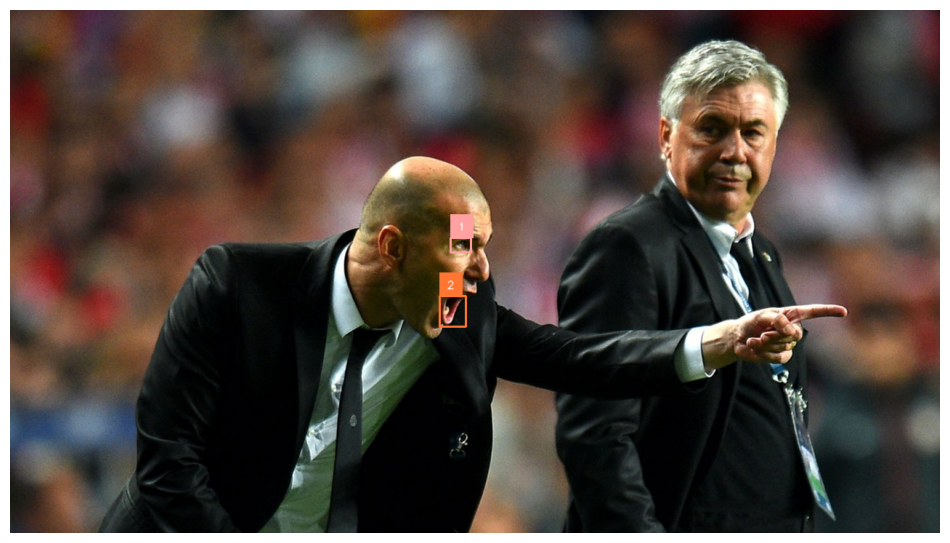

In [ ]:
detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(
    annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(
    annotated_image, detections, labels=labels)

sv.plot_image(annotated_image)

## Resume training from checkpoint

In [ ]:
import os

import locale
locale.getpreferredencoding = lambda: "UTF-8"

os.environ['CLEARML_PROJECT'] = 'Face parts detection'
os.environ['CLEARML_TASK'] = 'RTDETR PekingU/rtdetr_r50vd_coco_o365 resume'
os.environ['CLEARML_LOG_MODEL'] = 'True'

!export | grep CLEARML

declare -x CLEARML_API_ACCESS_KEY="2VF4R7JNVMN4CP6L52PB"
declare -x CLEARML_API_HOST="https://api.clear.ml"
declare -x CLEARML_API_SECRET_KEY="spBrPpI1ILCxGB80kker6HBpvhL9MLXj4rx0Vuadj20vrNRZHw"
declare -x CLEARML_FILES_HOST="https://files.clear.ml"
declare -x CLEARML_LOG_MODEL="True"
declare -x CLEARML_PROJECT="Face parts detection"
declare -x CLEARML_TASK="RTDETR PekingU/rtdetr_r50vd_coco_o365 resume"
declare -x CLEARML_WEB_HOST="https://app.clear.ml"


In [ ]:
CHECKPOINT = model_path

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

train_batch_size = 32
eval_batch_size = 16
warmup_steps = len(dataset_train) // train_batch_size

training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=20,
    max_grad_norm=0.1,
    learning_rate=1e-3,
    warmup_steps=warmup_steps,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Device: cuda


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


ClearML Task: created new task id=ce8b568e27064c8db1df5a66d1f148cc
ClearML results page: https://app.clear.ml/projects/3d72a693d1504c10a24dda3d8358cf80/experiments/ce8b568e27064c8db1df5a66d1f148cc/output/log
2024-11-16 08:04:00,344 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])
2024-11-16 08:04:06,109 - clearml.Task - INFO - Storing jupyter notebook directly as code


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map 0,Mar 100 0,Map 1,Mar 100 1,Map 2,Mar 100 2
1,12.096900,11.578253,0.180400,0.478800,0.087400,0.024300,0.194000,0.149100,0.240500,0.327900,0.370900,0.028200,0.377800,0.334800,0.189100,0.343200,0.124300,0.262500,0.227900,0.507000
2,13.249200,11.160929,0.050300,0.166400,0.017700,0.010300,0.054100,0.045800,0.077600,0.154700,0.232200,0.009900,0.202600,0.258600,0.080200,0.243800,0.043500,0.161900,0.027300,0.290900
3,12.676900,15.372216,0.008400,0.050600,0.000400,0.000000,0.011900,0.010000,0.032000,0.067700,0.095700,0.000000,0.060000,0.191800,0.015700,0.105500,0.002200,0.035200,0.007400,0.146500


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2024-11-16 08:10:51,590 - clearml.storage - INFO - Uploading: 488.47MB to /tmp/model_package.p5epxtb5.zip


████████████████████████████▉ 100% | 488.47/488.47 MB [00:48<00:00, 10.14MB/s]: 

2024-11-16 08:11:39,783 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365%20resume.ce8b568e27064c8db1df5a66d1f148cc/models/checkpoint-711.zip


2024-11-16 08:17:27,028 - clearml.storage - INFO - Uploading: 488.47MB to /tmp/model_package.jcepl3fh.zip


████████████████████████████▉ 100% | 488.47/488.47 MB [00:48<00:00, 10.14MB/s]: 

2024-11-16 08:18:15,231 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365%20resume.ce8b568e27064c8db1df5a66d1f148cc/models/checkpoint-1422.zip


2024-11-16 08:24:04,806 - clearml.storage - INFO - Uploading: 488.47MB to /tmp/model_package.2ac6lbhq.zip


████████████████████████████▉ 100% | 488.47/488.47 MB [00:48<00:00, 10.14MB/s]: 

2024-11-16 08:24:52,996 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Face%20parts%20detection/RTDETR%20PekingU/rtdetr_r50vd_coco_o365%20resume.ce8b568e27064c8db1df5a66d1f148cc/models/checkpoint-2133.zip
